In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib as plt
%matplotlib inline

## step one: data

### creating data 1.1: generating values with numpy

In [13]:
# create a large dataset: one million points

x_lin = np.linspace(0,10,1000000)

# create some noise
# pass in the number of points needed: same as x_lin

noise = np.random.rand(len(x_lin))

# check to see: these are just a million data points each
# linear distribution for x_lin
# random numbers from noise

print(x_lin, '\n', 'shape: ', x_lin.shape)
print('\n')
print(noise, '\n', 'shape: ', noise.shape)

[0.000000e+00 1.000001e-05 2.000002e-05 ... 9.999980e+00 9.999990e+00
 1.000000e+01] 
 shape:  (1000000,)


[0.1050464  0.8836699  0.01693174 ... 0.6580234  0.71009733 0.39138382] 
 shape:  (1000000,)


### creating data 1.2: dataframes using pandas

remember, we're modeling a line with the shape 

y = mx + b

let's set 

b = 5

and

m = 0.5

now generate this line (and add in the noise we created earlier):

In [15]:
b = 5
m = 0.5

# y = mx + b (and a little noise)

y_actual = m * x_lin + b + noise

creating dataframes using pandas:

In [18]:
# create a dataframe for X

X_data = pd.DataFrame(data=x_lin, columns=['X_data'])

X_data.head()

,X_data
0,0.00000
1,0.00001
2,0.00002
3,0.00003
4,0.00004


In [20]:
# create a dataframe for y

y_data = pd.DataFrame(data=y_actual, columns=['y'])

y_data.head()

,y
0,5.105046
1,5.883675
2,5.016942
3,5.146700
4,5.732145


merge (concatenate) the 2 dataframes together using pandas .concat() method:

In [26]:
# pass in dataframes to merge as a list
# add an axis to merge along columns vs rows
# axis=1 merges along columns

df = pd.concat([X_data, y_data], axis=1)

df.head()

,X_data,y
0,0.00000,5.105046
1,0.00001,5.883675
2,0.00002,5.016942
3,0.00003,5.146700
4,0.00004,5.732145


### visualizing the data

with 1 million data points, it would be difficult (if not impossible) to plot here in jupyter notebook (without crashing the kernel). using pandas, we can take a sample of any size we specify and plot that:

In [40]:
# grab a sample
# this one has 500 points

df_sample = df.sample(n=250)

df_sample.head()

,X_data,y
922667,9.226679,9.925184
492690,4.926905,7.800728
186800,1.868002,6.202724
313670,3.136703,7.400282
657222,6.572227,8.704005


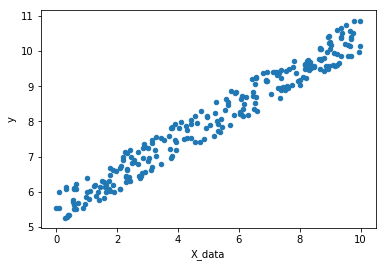

In [41]:
# now plot from the sample
# note: scatterplots require args for x and y

df_sample.plot(kind='scatter', x='X_data', y='y')

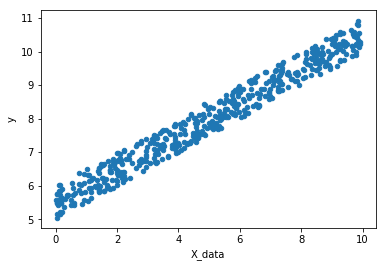

In [42]:
# this can all be done in 1 line, too
# here's a sample plot with 500 points

df.sample(n=500).plot(kind='scatter', x='X_data', y='y')

the plot with 500 sample points is a little more dense than the plot with 250.

we can also see there is definitely a linear fit (albeit with a little noise), a positive (upward) slope, and that the intercept is around 5, as we set before adding in the noise.

## step two: creating a model